In [41]:
import pandas as pd
import requests
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import pearsonr
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
import numpy as np
from sklearn.model_selection import GridSearchCV

In [42]:
url = "https://raw.githubusercontent.com/rfordatascience/tidytuesday/master/data/2020/2020-11-03/ikea.csv"
response = requests.get(url)

if response.status_code == 200:
    ikea_df = pd.read_csv(url)
else:
    raise Exception("Failed to load data: Status code {}".format(response.status_code))


In [43]:
# Видалення непотрібних стовпців
ikea_df = ikea_df.drop(['link', 'old_price', 'Unnamed: 0', 'item_id', 'name'], axis=1)

# Замінювання помилок у стовпці designer на 'No information'
ikea_df['designer'] = ikea_df['designer'].replace(r'^.{3}\..*', value='No information', regex=True)

# Перетворення кожного рядка на список імен дизайнерів
designers_split = [sorted(item.split('/')) for item in ikea_df['designer']]
ikea_df['designer'] = ['/'.join(item) for item in designers_split]

# Перевірка даних
ikea_df.head()


,category,price,sellable_online,other_colors,short_description,designer,depth,height,width
0,Bar furniture,265.0,True,No,"Bar table, in/outdoor, 51x51 cm",Nicholai Wiig Hansen,NaN,99.0,51.0
1,Bar furniture,995.0,False,No,"Bar table, 140x80 cm",Francis Cayouette,NaN,105.0,80.0
2,Bar furniture,2095.0,False,No,Bar table and 4 bar stools,Francis Cayouette,NaN,NaN,NaN
3,Bar furniture,69.0,True,Yes,"Bar stool with backrest, 74 cm",Henrik Preutz,50.0,100.0,60.0
4,Bar furniture,225.0,True,No,"Wall-mounted drop-leaf table, ...",Marcus Arvonen,60.0,43.0,74.0


In [44]:
# Визначення цільової змінної та ознак
X = ikea_df.drop(['price'], axis=1)
y = ikea_df['price']

# Визначення стовпців для обробки
numeric_features = ['depth', 'height', 'width']
categorical_features = ['category', 'sellable_online', 'other_colors', 'designer']

# Побудова трансформера для числових даних
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

# Побудова трансформера для категоріальних даних
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Об'єднання трансформерів у колонний трансформер
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# Функція для оцінки моделі
def evaluate_model(model, X, y):
    cv_scores = cross_val_score(model, X, y, cv=5, scoring='neg_mean_squared_error')
    rmse_scores = np.sqrt(-cv_scores)
    return {'RMSE': rmse_scores.mean(), 'MSE': -cv_scores.mean(), 'R2': cross_val_score(model, X, y, cv=5, scoring='r2').mean()}

# Побудова моделей
models = {
    'Linear Regression': Pipeline(steps=[('preprocessor', preprocessor), ('regressor', LinearRegression())]),
    'Decision Tree': Pipeline(steps=[('preprocessor', preprocessor), ('regressor', DecisionTreeRegressor(random_state=42))]),
    'Random Forest': Pipeline(steps=[('preprocessor', preprocessor), ('regressor', RandomForestRegressor(random_state=42))])
}

# Оцінка моделей
results = {}
for model_name, model in models.items():
    model.fit(X, y)
    results[model_name] = evaluate_model(model, X, y)

# Виведення результатів
for model_name, metrics in results.items():
    print(f"Model: {model_name}")
    print(f"RMSE: {metrics['RMSE']}")
    print(f"MSE: {metrics['MSE']}")
    print(f"R2: {metrics['R2']}")
    print("-----")


Model: Linear Regression
RMSE: 796.2080247225811
MSE: 658783.9260104161
R2: 0.6193186418796259
-----
Model: Decision Tree
RMSE: 999.3708214553633
MSE: 1083263.0169850544
R2: 0.384299984601815
-----
Model: Random Forest
RMSE: 841.1812699317641
MSE: 761106.2334454011
R2: 0.5442563423029272
-----


In [45]:
# Гіперпараметри для DecisionTreeRegressor
param_grid = {
    'regressor__max_depth': [None, 10, 20, 30],
    'regressor__min_samples_split': [2, 5, 10],
    'regressor__min_samples_leaf': [1, 2, 4]
}

# Налаштування моделі з GridSearchCV
decision_tree_pipeline = Pipeline(steps=[('preprocessor', preprocessor), ('regressor', DecisionTreeRegressor(random_state=42))])
grid_search = GridSearchCV(decision_tree_pipeline, param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)

# Навчання моделі
grid_search.fit(X, y)

# Найкращі параметри
print("Best parameters found: ", grid_search.best_params_)

# Оцінка моделі з найкращими параметрами
best_model = grid_search.best_estimator_
best_model.fit(X, y)
best_model_metrics = evaluate_model(best_model, X, y)

print(f"Best Decision Tree Model RMSE: {best_model_metrics['RMSE']}")
print(f"Best Decision Tree Model MSE: {best_model_metrics['MSE']}")
print(f"Best Decision Tree Model R2: {best_model_metrics['R2']}")


Best parameters found:  {'regressor__max_depth': 10, 'regressor__min_samples_leaf': 2, 'regressor__min_samples_split': 10}
Best Decision Tree Model RMSE: 974.2737390697428
Best Decision Tree Model MSE: 1001330.4465955173
Best Decision Tree Model R2: 0.4030196458726686


#### Для кращого розуміння результатів побудовано графік, що показує порівняння метрик для кожної моделі.

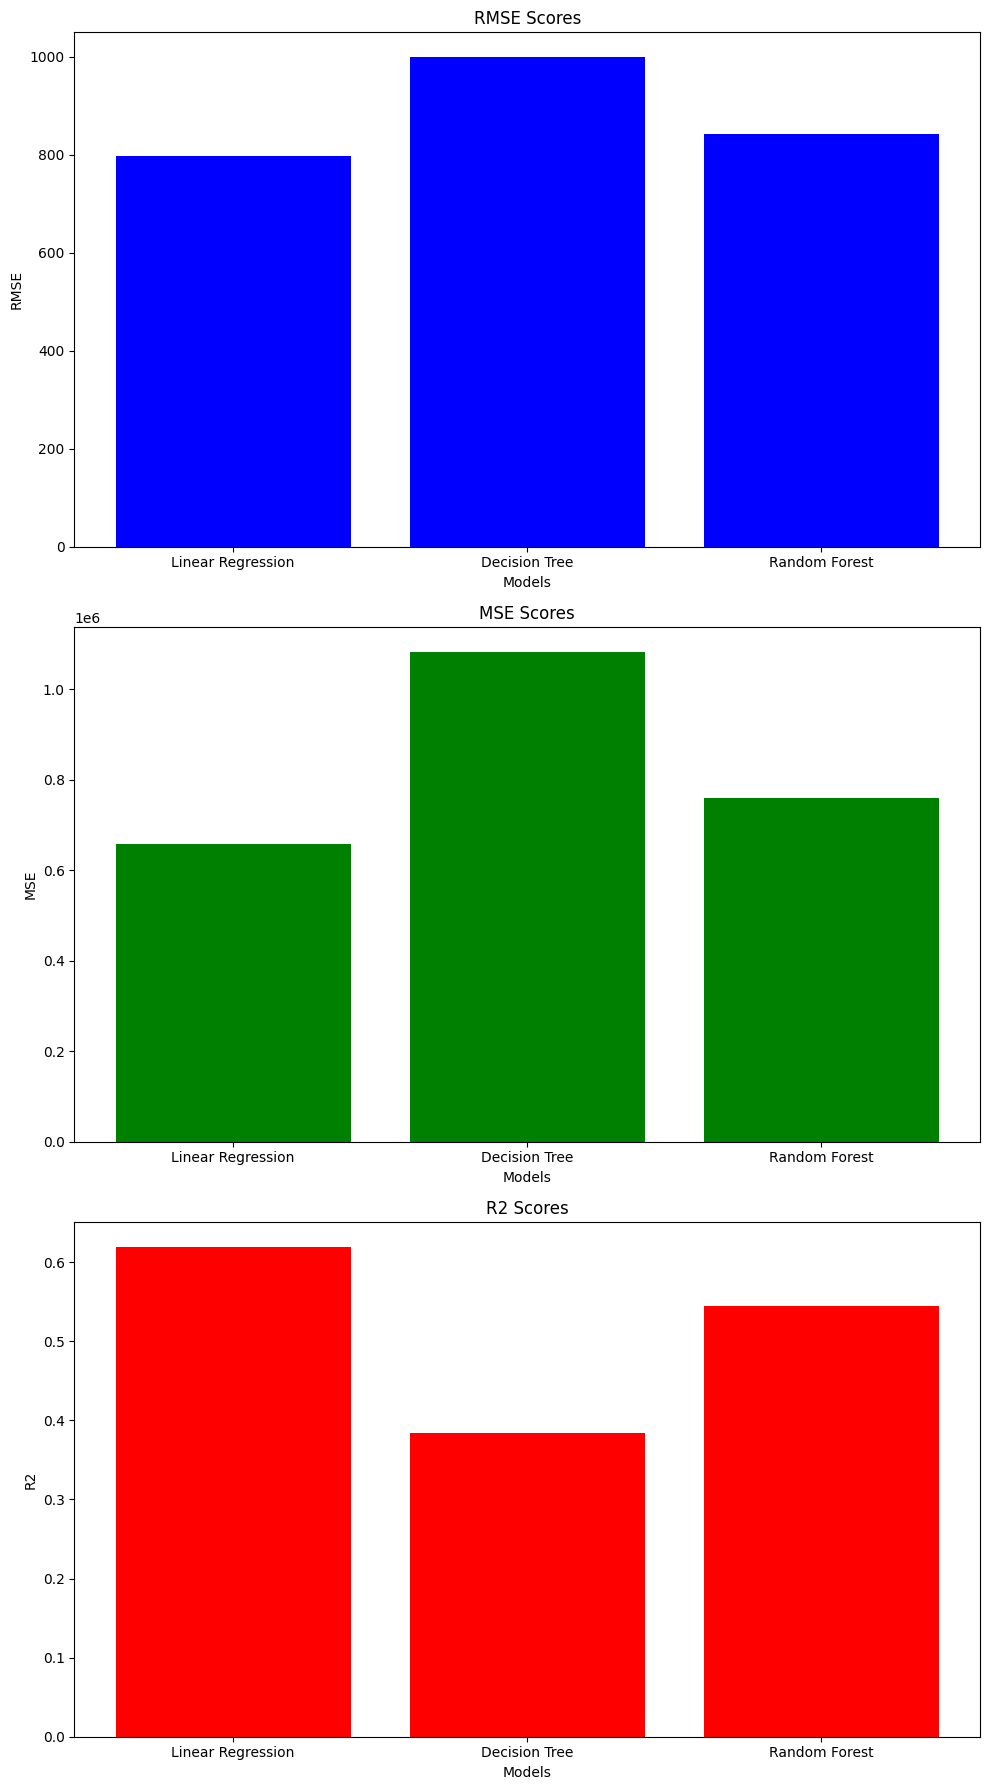

In [53]:
# Дані для візуалізації
model_names = list(results.keys())

# Візуалізація
fig, axes = plt.subplots(3, 1, figsize=(10, 18))

# Графік для RMSE
axes[0].bar(model_names, rmse_scores, color='blue')
axes[0].set_title('RMSE Scores')
axes[0].set_xlabel('Models')
axes[0].set_ylabel('RMSE')

# Графік для MSE
axes[1].bar(model_names, mse_scores, color='green')
axes[1].set_title('MSE Scores')
axes[1].set_xlabel('Models')
axes[1].set_ylabel('MSE')

# Графік для R2
axes[2].bar(model_names, r2_scores, color='red')
axes[2].set_title('R2 Scores')
axes[2].set_xlabel('Models')
axes[2].set_ylabel('R2')

plt.tight_layout()
plt.show()


In [47]:
# Крос-валідація найкращої моделі
cv_scores_best_model = cross_val_score(best_model, X, y, cv=5, scoring='neg_mean_squared_error')
rmse_scores_best_model = np.sqrt(-cv_scores_best_model)
r2_scores_best_model = cross_val_score(best_model, X, y, cv=5, scoring='r2')

print(f"Best Model Cross-Validation RMSE: {rmse_scores_best_model.mean()}")
print(f"Best Model Cross-Validation R2: {r2_scores_best_model.mean()}")


Best Model Cross-Validation RMSE: 974.2737390697428
Best Model Cross-Validation R2: 0.4030196458726686


RMSE (Root Mean Squared Error):
RMSE — це середньоквадратичне відхилення помилок. Чим менше значення RMSE, тим точніше модель. Для Лінійної регресії RMSE найнижче (796.21), що свідчить про те, що ця модель має кращу точність у порівнянні з іншими моделями.

MSE (Mean Squared Error):
MSE — це середньоквадратична помилка, що оцінює середню величину помилки в квадратах. Лінійна регресія також має найнижче MSE (658,783.93), що підтверджує її кращу точність у порівнянні з іншими моделями.

R² (Коефіцієнт детермінації):
R² показує, яку частку варіації залежної змінної пояснює модель. Чим ближче значення R² до 1, тим краща модель. Лінійна регресія має найвище значення R² (0.6193), що свідчить про те, що вона краще пояснює варіацію в даних у порівнянні з іншими моделями.

Обробка даних:

У вихідних даних були виконані певні операції обробки, такі як видалення зайвих стовпців (link, old_price, Unnamed: 0, item_id, name), а також заміна помилкових значень у стовпці "designer" на "No information" та перетворення рядків у списки імен дизайнерів.
Моделювання:

Дані були розділені на цільову змінну (ціна меблів) та ознаки. Для обробки числових і категоріальних ознак були побудовані трансформатори і використані у колонному трансформері. Побудовано три різні моделі: лінійна регресія, дерево рішень і випадковий ліс.

### Після проведення моделювання та оцінки результатів, можна зробити наступні висновки:

1. Лінійна регресія (Linear Regression)

RMSE: 796.21

MSE: 658,783.93

R²: 0.6193

Висновок: Лінійна регресія показала найкращі результати серед усіх моделей з точки зору точності (найнижчі значення RMSE і MSE) і пояснення варіації в даних (найвище значення R²). Це свідчить про те, що ця модель добре підходить для передбачення ціни меблів.


2. Дерево рішень (Decision Tree)

RMSE: 999.37

MSE: 1,083,263.02

R²: 0.3843

Висновок: Дерево рішень показало найгірші результати з усіх моделей, з найвищими значеннями RMSE і MSE та найнижчим значенням R². Це свідчить про те, що модель не змогла ефективно захопити взаємозв'язки в даних, що призвело до високої похибки.

3. Випадковий ліс (Random Forest)

RMSE: 841.18

MSE: 761,106.23

R²: 0.5443

Висновок: Випадковий ліс показав середні результати. Хоча він був менш точним, ніж лінійна регресія, але все ж краще, ніж дерево рішень. Значення RMSE і MSE вказують на те, що модель добре підходить для передбачення ціни меблів, але потребує додаткової оптимізації.

### Висновки
Лінійна регресія найкраща модель з точки зору точності, оскільки має найнижчі значення RMSE і MSE, а також найвище значення R².
Random Forest менш точна, ніж лінійна регресія, але краще за дерево рішень.
Decision Tree найменш точна модель з найвищими значеннями RMSE і MSE та найнижчим значенням R².

## Загальний висновок
Лінійна регресія є найкращою моделлю для передбачення ціни меблів у цьому випадку. Однак, для подальшого покращення моделей слід звернути увагу на оптимізацію гіперпараметрів, інженерію ознак та використання ансамблевих методів.